# Regime transition probability on synthetic ensembles

This notebook recreates Figure 7 from the original publication, analyzing LERM applied to synthetic ensembles.

This notebook produces a combined KDE figure for both the abrupt and gradual regime transition examples associated with this folder.

In [1]:
import warnings
import pickle
from tqdm import tqdm
from collections import OrderedDict

import pyleoclim as pyleo
import numpy as np
import ammonyte as amt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde
from pylipd.lipd import LiPD

/Users/alexjames/miniconda3/envs/ammonyte/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#We suppress warnings for these notebooks for presentation purposes. Best practice is to not do this though.
import warnings
warnings.filterwarnings('ignore')

### Load ODP record

In [3]:
#Defining group lists for easy loading
group_names = ['ODP 925'] #,'ODP 927','ODP 929','ODP 846','ODP 849']

Time axis values sorted in ascending order


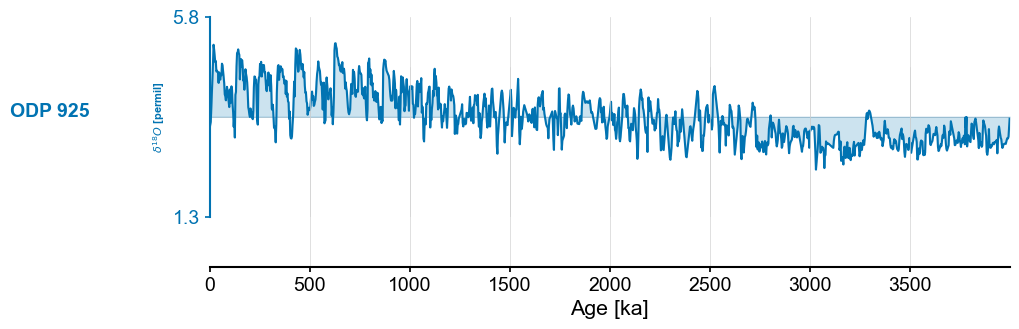

In [4]:
series_list = []
color_list = sns.color_palette('colorblind')

for name in group_names:
    with open('../data/LR04cores_spec_corr/'+name[-3:]+'_LR04age.txt','rb') as handle:
        lines = handle.readlines()
        time = []
        d18O = []
        for x in lines:
            line_time = float(format(float(x.decode().split()[1]),'10f'))
            line_d18O = float(format(float(x.decode().split()[2]),'10f'))
            #There is a discontinuity in 927 around 4000 ka, we'll just exclude it
            if line_time <= 4000:
                time.append(line_time)
                d18O.append(line_d18O)
        series = pyleo.Series(value=d18O,
                              time=time,
                              label=name,
                              time_name='Yr',
                              time_unit='ka',
                              value_name=r'$\delta^{18}O$',
                              value_unit='permil')
    series_list.append(series)
    
max_time = min([max(series.time) for series in series_list])
min_time = max([min(series.time) for series in series_list])

ms = pyleo.MultipleSeries([series.slice((min_time,max_time)).interp() for series in series_list])
fig,ax = ms.stackplot(colors=color_list[:len(ms.series_list)],figsize=(8,2*len(ms.series_list)))

### Load NGRIP record

In [5]:
end_time=10000

# Using pylipd to load the data

D = LiPD()
D.load('../data/8k_ice/NGRIP.NGRIP.2004.lpd')
df = D.get_timeseries_essentials()
row = df[df['time_variableName']=='age']

NGRIP_series = pyleo.Series(
    value=row['paleoData_values'].iloc[0],
    time=row['time_values'].iloc[0],
    value_name = row['paleoData_variableName'].iloc[0],
    value_unit = row['paleoData_units'].iloc[0],
    time_name = row['time_variableName'].iloc[0],
    time_unit = row['time_units'].iloc[0],
    label='NGRIP',
).slice((0,end_time))

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00, 46.64it/s]

Loaded..
Time axis values sorted in ascending order


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [yr BP]', ylabel='d18O [permil]'>)

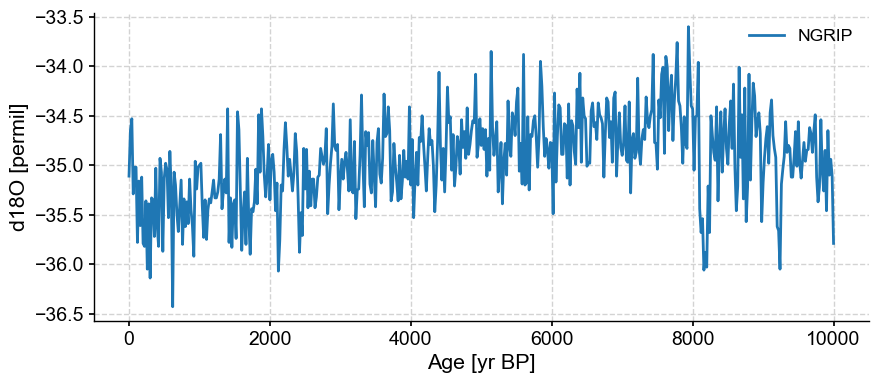

In [6]:
NGRIP_series.plot()

### Defining functions

In [7]:
# This function can be used to calculate when transitions occur. It isn't used in this notebook as the calculations were performed previously
def detect_transitions(series,transition_interval=None):
    '''Function to detect transitions across a confidence interval
    
    Parameters
    ----------
    
    series : pyleo.Series, amt.Series
        Series to detect transitions upon
        
    transition_interval : list,tuple
        Upper and lower bound for the transition interval
    
    Returns
    -------
    
    transitions : list
        Timing of the transitions of the series across its confidence interval
    '''
    series_fine = series.interp(step=1)
    
    if transition_interval is None:
        upper, lower = amt.utils.sampling.confidence_interval(series)
    else:
        upper, lower = transition_interval

    above_thresh = np.where(series_fine.value > upper,1,0)
    below_thresh = np.where(series_fine.value < lower,1,0)

    transition_above = np.diff(above_thresh)
    transition_below = np.diff(below_thresh)

    upper_trans = series_fine.time[1:][np.diff(above_thresh) != 0]
    lower_trans = series_fine.time[1:][np.diff(below_thresh) != 0]

    full_trans = np.zeros(len(transition_above))

    last_above = 0
    last_below = 0
    for i in range(len(transition_above)):
        above = transition_above[i]
        below = transition_below[i]
        if above != 0:
            if last_below+above == 0:
                loc = int((i+below_pointer)/2)
                full_trans[loc] = 1
                last_below=0
            last_above = above
            above_pointer = i
        if below != 0:
            if last_above + below == 0:
                loc = int((i+above_pointer)/2)
                full_trans[loc] = 1
                last_above=0
            last_below = below
            below_pointer = i

    transitions = series_fine.time[1:][full_trans != 0]
    
    return transitions

### Plotting

The calculations used to produce these results were all done separately, so we just load the pickle files with the results here. We used the same parameteres as those from Figures 3 and 5.

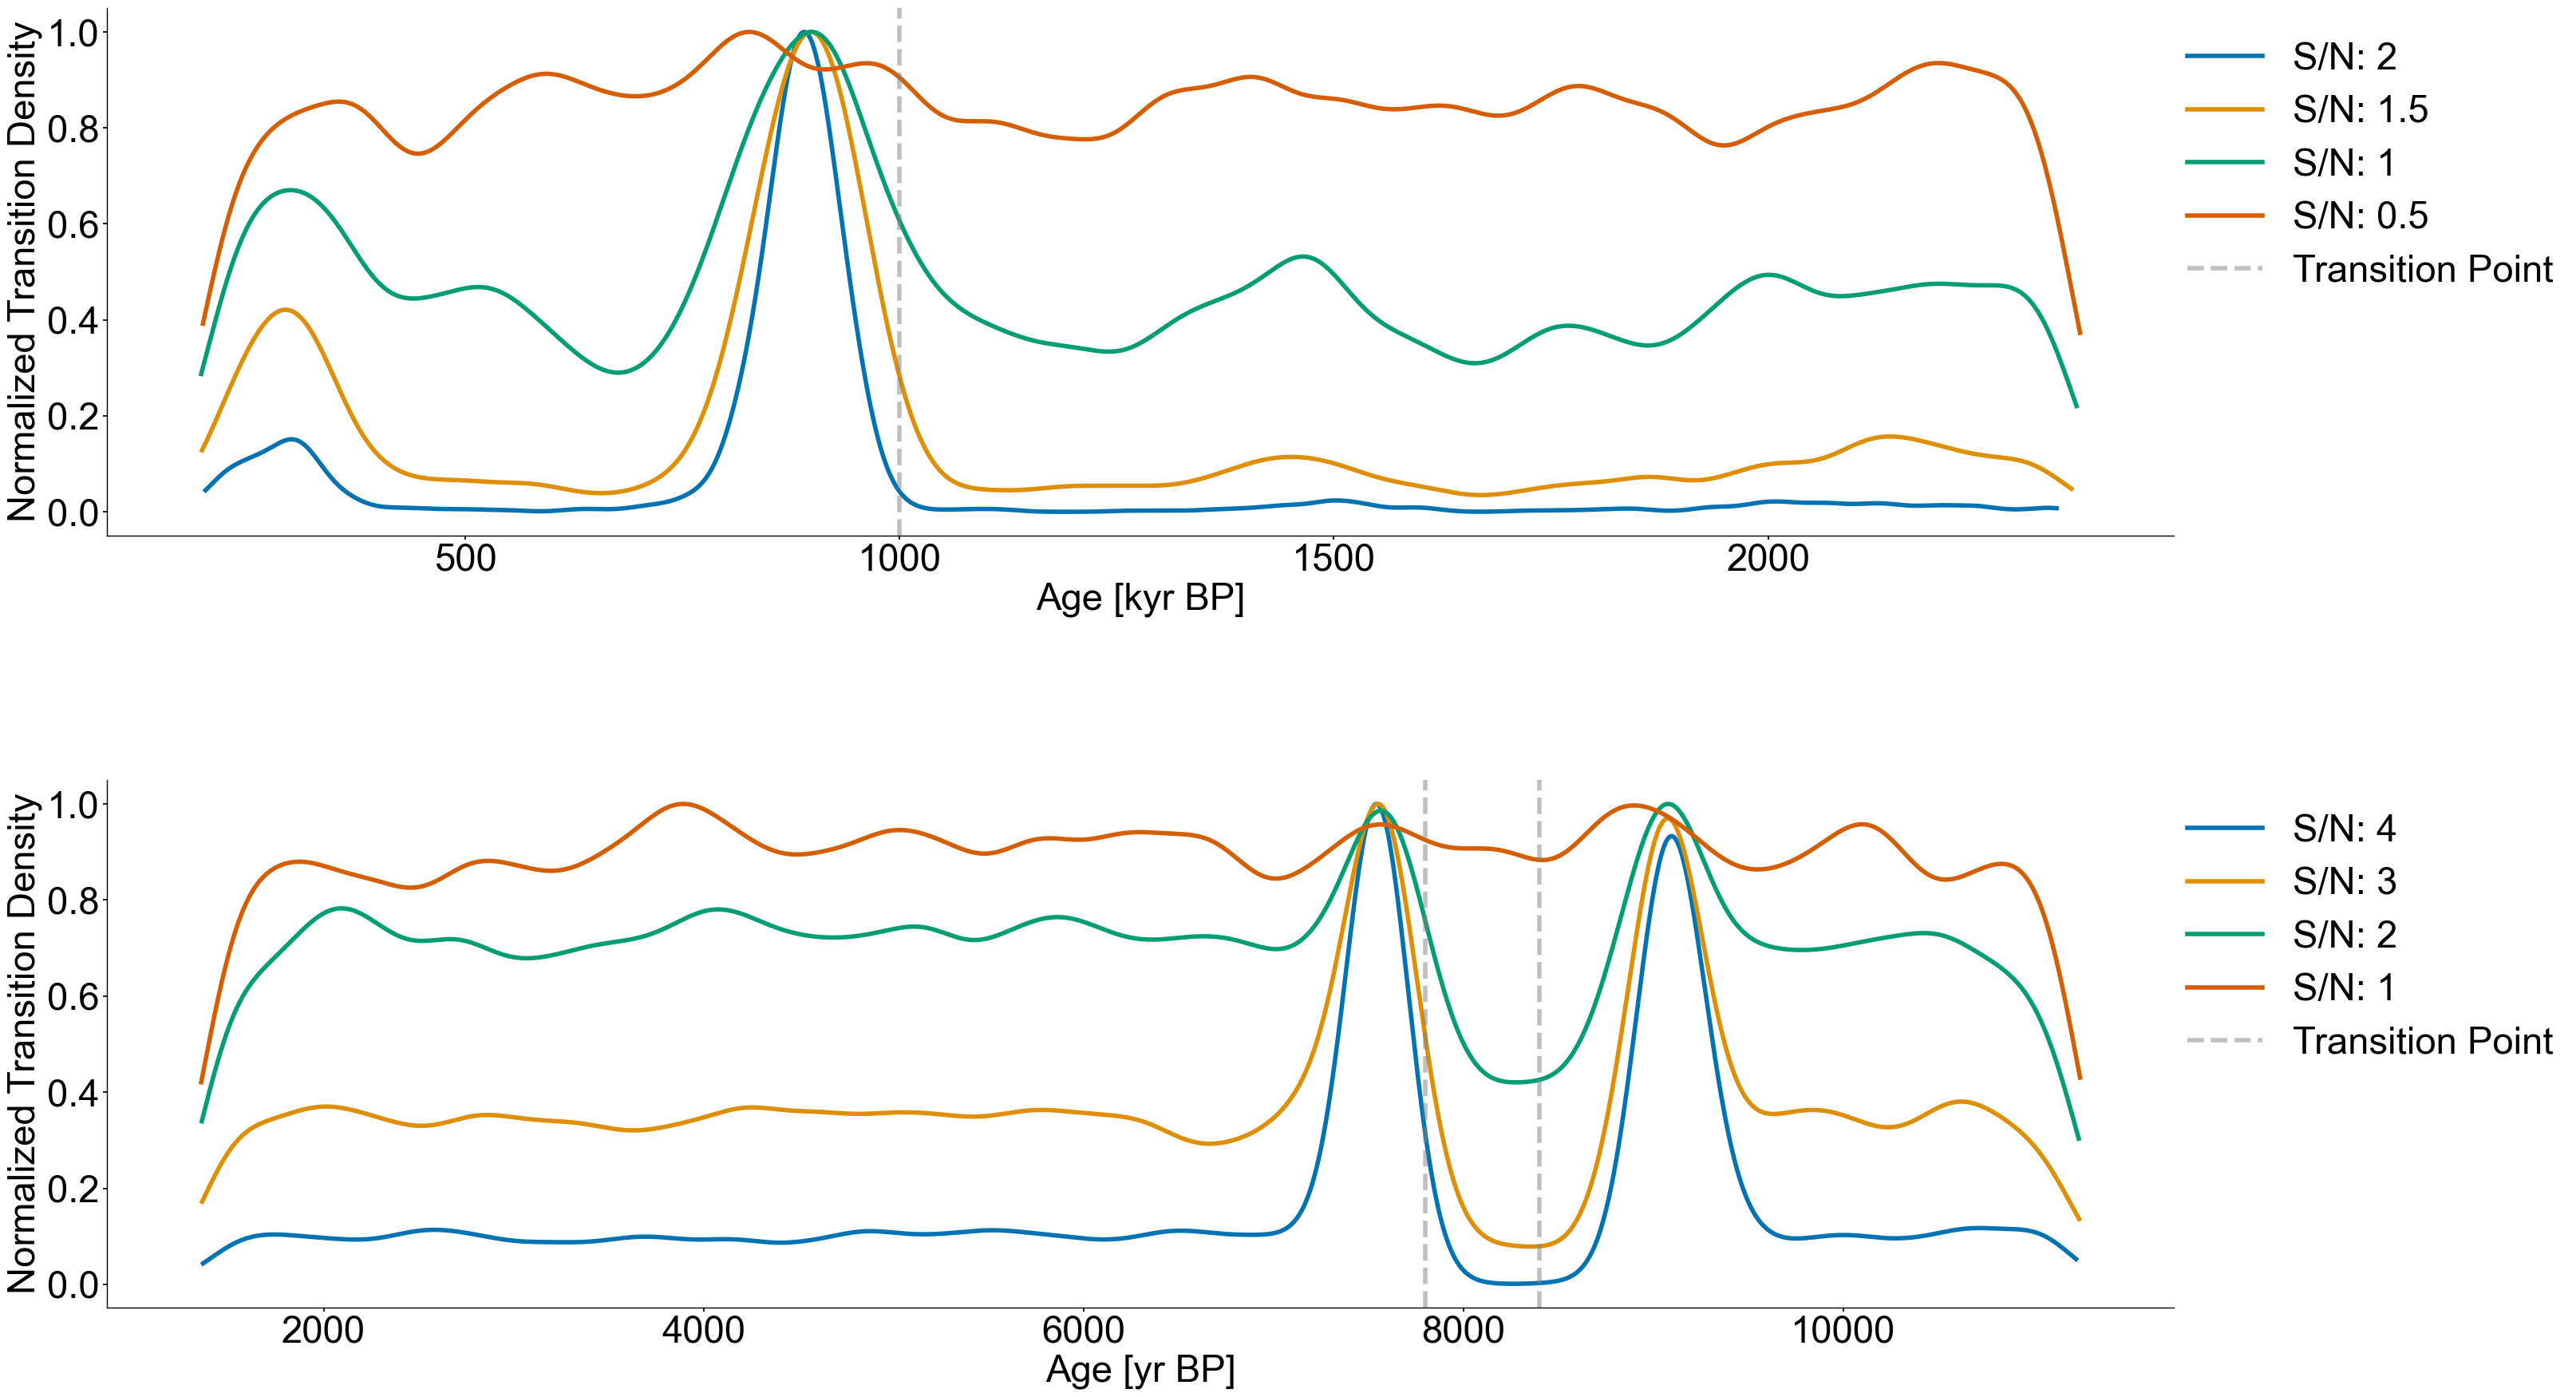

In [8]:
#Production figure

color_list = sns.color_palette('colorblind',4)

SMALL_SIZE = 34
MEDIUM_SIZE = 34
BIGGER_SIZE = 34

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig,ax = plt.subplots(figsize=(28,18),nrows=2)
fig.tight_layout(h_pad=5, w_pad=5)
axes = ax.ravel()

with open('../data/leloup_paillard_transitions.pkl','rb') as handle:
    trans_res = pickle.load(handle)

noise_levels = [2,1.5,1,.5]

for idx,level in enumerate(noise_levels):
    transition_hist = trans_res[level]

    kde = gaussian_kde(transition_hist,bw_method=.06)
    x_axis = np.linspace(transition_hist.min(),transition_hist.max(),10000)
    evaluated = kde.evaluate(x_axis)
    evaluated /= max(evaluated)

    axes[0].plot(x_axis,evaluated,label=f'S/N: {level}',color=color_list[idx],linewidth=4)

    axes[0].grid(False)
    axes[0].set_xlabel('Age [kyr BP]')
    axes[0].set_ylabel('Normalized Transition Density')
    
axes[0].axvline(1000,color='grey',linestyle='dashed',alpha=.5,linewidth=4,label='Transition Point')
axes[0].legend(bbox_to_anchor=(1.2,1),loc='upper right')

with open('../data/8k_transitions.pkl','rb') as handle:
    trans_res = pickle.load(handle)

noise_levels = [4,3,2,1]

for idx,level in enumerate(noise_levels):
    transition_hist = trans_res[level]

    kde = gaussian_kde(transition_hist,bw_method=.06)
    x_axis = np.linspace(transition_hist.min(),transition_hist.max(),10000)
    evaluated = kde.evaluate(x_axis)
    evaluated /= max(evaluated)

    axes[1].plot(x_axis,evaluated,label=f'S/N: {level}',color=color_list[idx],linewidth=4)
    # ax.axvspan(7200,7800,color='grey',alpha=.3,label='Positive Range')
    # ax.axvspan(8800,9600,color='grey',alpha=.3)
    
    axes[1].grid(False)
    axes[1].set_xlabel('Age [yr BP]')
    axes[1].set_ylabel('Normalized Transition Density')
    
axes[1].axvline(7800,color='grey',linestyle='dashed',alpha=.5,linewidth=4,label='Transition Point')
axes[1].axvline(8400,color='grey',linestyle='dashed',alpha=.5,linewidth=4)
axes[1].legend(bbox_to_anchor=(1.2,1),loc='upper right')